In [230]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

import joblib

In [231]:
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')

In [232]:
df = pd.read_csv('Bronx_data.csv', index_col=[0])
df.head()

,Borough,Neighborhood,Building_Class_Category,Tax Class At Present,Block,Lot,Ease-Ment,Building Class At Present,address,Apartment Number,...,Total Units,Land_Square_Feet,Gross Square Feet,Year Built,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,sale date,latitude,longitude
0,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3030,70,NaN,A1,4445 PARK AVENUE,NaN,...,1.0,1694.0,1497.0,1899.0,1,A1,388500,2019-07-23 00:00:00,40.853803,-73.896342
1,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3039,29,NaN,A9,2327 WASHINGTON AVENUE,NaN,...,1.0,1095.0,1260.0,1910.0,1,A9,110000,2019-12-06 00:00:00,40.856048,-73.892731
2,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3043,55,NaN,A1,1948 BATHGATE AVENUE,NaN,...,1.0,2356.0,2047.0,1901.0,1,A1,470000,2019-03-08 00:00:00,40.847655,-73.896431
3,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3046,39,NaN,A1,2075 BATHGATE AVENUE,NaN,...,1.0,1986.0,1344.0,1899.0,1,A1,420000,2019-05-24 00:00:00,40.850712,-73.895295
4,2,BATHGATE,02 TWO FAMILY DWELLINGS,1,2912,137,NaN,B1,496 CLAREMONT PARKWAY,NaN,...,2.0,2000.0,2400.0,1993.0,1,B1,0,2019-06-12 00:00:00,40.838202,-73.901889


In [234]:
df['Sale_Price'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])


0.000           0.0
0.250           0.0
0.500      245000.0
0.750      575000.0
0.900      830000.0
0.950     1671250.0
0.990     9434000.0
0.997    22500000.0
1.000    89000000.0
Name: Sale_Price, dtype: float64

In [235]:
df['Year Built'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])


0.000    1800.0
0.250    1925.0
0.500    1946.0
0.750    1962.0
0.900    1999.0
0.950    2006.0
0.990    2017.0
0.997    2018.0
1.000    2019.0
Name: Year Built, dtype: float64

In [237]:
mask = (df['Year Built'] > 1900) & (df['Sale_Price'] > 100000) & (df['Sale_Price'] < 1e7)
df = df[mask]

In [238]:
df.shape


(4396, 23)

In [239]:
req_cols = []

for col in df.columns:
    is_na = round(df[col].isna().sum() / len(df) * 100, 2)
    if is_na < 50:
        req_cols.append(col)
    print(f"{col} has {is_na} % of nan values")

print(f"{len(req_cols)} has less than 50% of nan values")
df = df[req_cols]
print(df.shape)

Borough has 0.0 % of nan values
Neighborhood has 0.0 % of nan values
Building_Class_Category has 0.0 % of nan values
Tax Class At Present has 0.0 % of nan values
Block has 0.0 % of nan values
Lot has 0.0 % of nan values
Ease-Ment has 100.0 % of nan values
Building Class At Present has 0.0 % of nan values
address has 0.0 % of nan values
Apartment Number has 95.5 % of nan values
Zip Code has 0.0 % of nan values
Residential_Units has 21.91 % of nan values
Commercial_Units has 21.91 % of nan values
Total Units has 21.91 % of nan values
Land_Square_Feet has 21.91 % of nan values
Gross Square Feet has 21.91 % of nan values
Year Built has 0.0 % of nan values
Tax_Class_At_Time_Of_Sale has 0.0 % of nan values
Building_Class_At_Time_Of_Sale has 0.0 % of nan values
Sale_Price has 0.0 % of nan values
sale date has 0.0 % of nan values
latitude has 40.04 % of nan values
longitude has 40.04 % of nan values
21 has less than 50% of nan values
(4396, 21)


In [240]:
cat_cols = df.select_dtypes('object').columns
k = 0
cardinality_cols = []

for col in cat_cols:
    value_counts = df[col].value_counts(normalize=True).round(2)
    if len(value_counts) > 5 or len(value_counts) < 2:
        cardinality_cols.append(col)
    else:
        print("====================================================================")
        print(col)
        print(value_counts)

cardinality_cols.remove('Neighborhood')
cardinality_cols.remove('Building_Class_At_Time_Of_Sale')
print(f"Removed Columns: {cardinality_cols}")
df.drop(columns=cardinality_cols, axis=1, inplace=True)

Removed Columns: ['Building_Class_Category', 'Tax Class At Present', 'Building Class At Present', 'address', 'sale date']


In [241]:
df['Neighborhood'].value_counts(normalize=True).round(2)


RIVERDALE                    0.11
BAYCHESTER                   0.07
SOUNDVIEW                    0.07
WILLIAMSBRIDGE               0.07
THROGS NECK                  0.06
BRONXDALE                    0.05
SCHUYLERVILLE/PELHAM BAY     0.04
MORRISANIA/LONGWOOD          0.04
WAKEFIELD                    0.04
BEDFORD PARK/NORWOOD         0.04
MORRIS PARK/VAN NEST         0.03
MELROSE/CONCOURSE            0.03
COUNTRY CLUB                 0.03
KINGSBRIDGE/JEROME PARK      0.03
CASTLE HILL/UNIONPORT        0.02
KINGSBRIDGE HTS/UNIV HTS     0.02
WESTCHESTER                  0.02
PARKCHESTER                  0.02
CITY ISLAND                  0.02
PELHAM PARKWAY NORTH         0.02
MOTT HAVEN/PORT MORRIS       0.02
HIGHBRIDGE/MORRIS HEIGHTS    0.02
PELHAM PARKWAY SOUTH         0.02
EAST TREMONT                 0.01
WOODLAWN                     0.01
HUNTS POINT                  0.01
FORDHAM                      0.01
BELMONT                      0.01
BATHGATE                     0.01
PELHAM GARDENS

In [242]:
neighborhood = df['Neighborhood'].value_counts(normalize=True).round(2)
idx = np.where(neighborhood > 0.01)[0].max()
places = neighborhood.index[:idx]
df['Neighborhood'] =df['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
df['Neighborhood'].value_counts(normalize=True)

OTHER                        0.118517
RIVERDALE                    0.110100
BAYCHESTER                   0.073703
SOUNDVIEW                    0.072566
WILLIAMSBRIDGE               0.068016
THROGS NECK                  0.063467
BRONXDALE                    0.049818
SCHUYLERVILLE/PELHAM BAY     0.044131
MORRISANIA/LONGWOOD          0.041856
WAKEFIELD                    0.038444
BEDFORD PARK/NORWOOD         0.037534
MORRIS PARK/VAN NEST         0.033439
MELROSE/CONCOURSE            0.030710
COUNTRY CLUB                 0.029117
KINGSBRIDGE/JEROME PARK      0.026388
CASTLE HILL/UNIONPORT        0.024568
KINGSBRIDGE HTS/UNIV HTS     0.022748
WESTCHESTER                  0.021611
PARKCHESTER                  0.020928
CITY ISLAND                  0.018426
PELHAM PARKWAY NORTH         0.018198
MOTT HAVEN/PORT MORRIS       0.017971
HIGHBRIDGE/MORRIS HEIGHTS    0.017743
Name: Neighborhood, dtype: float64

In [243]:
building_class = df['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
idx = np.where(building_class > 0.01)[0].max()
places = building_class.index[:idx]
df['Building_Class_At_Time_Of_Sale'] =df['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
df['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True)


D4       0.198362
OTHER    0.159691
B1       0.137625
C0       0.097816
B2       0.088717
A1       0.087580
A5       0.086897
B3       0.054823
A2       0.029572
R3       0.021156
C3       0.020246
B9       0.017516
Name: Building_Class_At_Time_Of_Sale, dtype: float64

In [244]:
df.shape


(4396, 16)

In [245]:
num_cols = df.select_dtypes('number').columns

low_var_cols = []
for col in num_cols:
    scaled = (df[col] - df[col].mean()) / df[col].std()
    variance = scaled.var()
    if variance == 0 or df[col].std() == 0:
        low_var_cols.append(col)
#     else:
#         print(col, variance)

df.drop(columns=low_var_cols, axis=1, inplace=True)
print(f"Removed Columns: {low_var_cols}")
print(df.shape, len(low_var_cols))

Removed Columns: ['Borough']
(4396, 15) 1


In [246]:
df['age'] = 2023 - (df['Year Built'] + df['Year Built']) // 2
df.drop(['Zip Code', 'Year Built'], axis=1, inplace=True)

In [247]:
df

,Neighborhood,Block,Lot,Residential_Units,Commercial_Units,Total Units,Land_Square_Feet,Gross Square Feet,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,latitude,longitude,age
1,OTHER,3039,29,1.0,0.0,1.0,1095.0,1260.0,1,OTHER,110000,40.856048,-73.892731,113.0
2,OTHER,3043,55,1.0,0.0,1.0,2356.0,2047.0,1,A1,470000,40.847655,-73.896431,122.0
5,OTHER,2912,149,2.0,0.0,2.0,2000.0,2400.0,1,B1,505000,40.837378,-73.902013,30.0
6,OTHER,2912,152,2.0,0.0,2.0,2000.0,2400.0,1,B1,630000,40.837455,-73.902211,30.0
7,OTHER,2927,119,2.0,0.0,2.0,1900.0,2394.0,1,B1,535000,40.836752,-73.901490,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279,OTHER,3398,97,NaN,NaN,NaN,NaN,NaN,2,D4,211907,NaN,NaN,66.0
8280,OTHER,3398,97,NaN,NaN,NaN,NaN,NaN,2,D4,195529,NaN,NaN,66.0
8281,OTHER,3398,97,NaN,NaN,NaN,NaN,NaN,2,D4,192568,NaN,NaN,66.0
8282,OTHER,3398,97,NaN,NaN,NaN,NaN,NaN,2,D4,225000,NaN,NaN,66.0


In [249]:
corr = df.drop('Sale_Price', axis=1).corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
print(f"columns dropped are: {drop}")
df.drop(columns=drop, axis=1, inplace=True)

columns dropped are: ['Total Units', 'Land_Square_Feet', 'Gross Square Feet', 'longitude']


/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_2625/1701191774.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop('Sale_Price', axis=1).corr()
/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_2625/1701191774.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


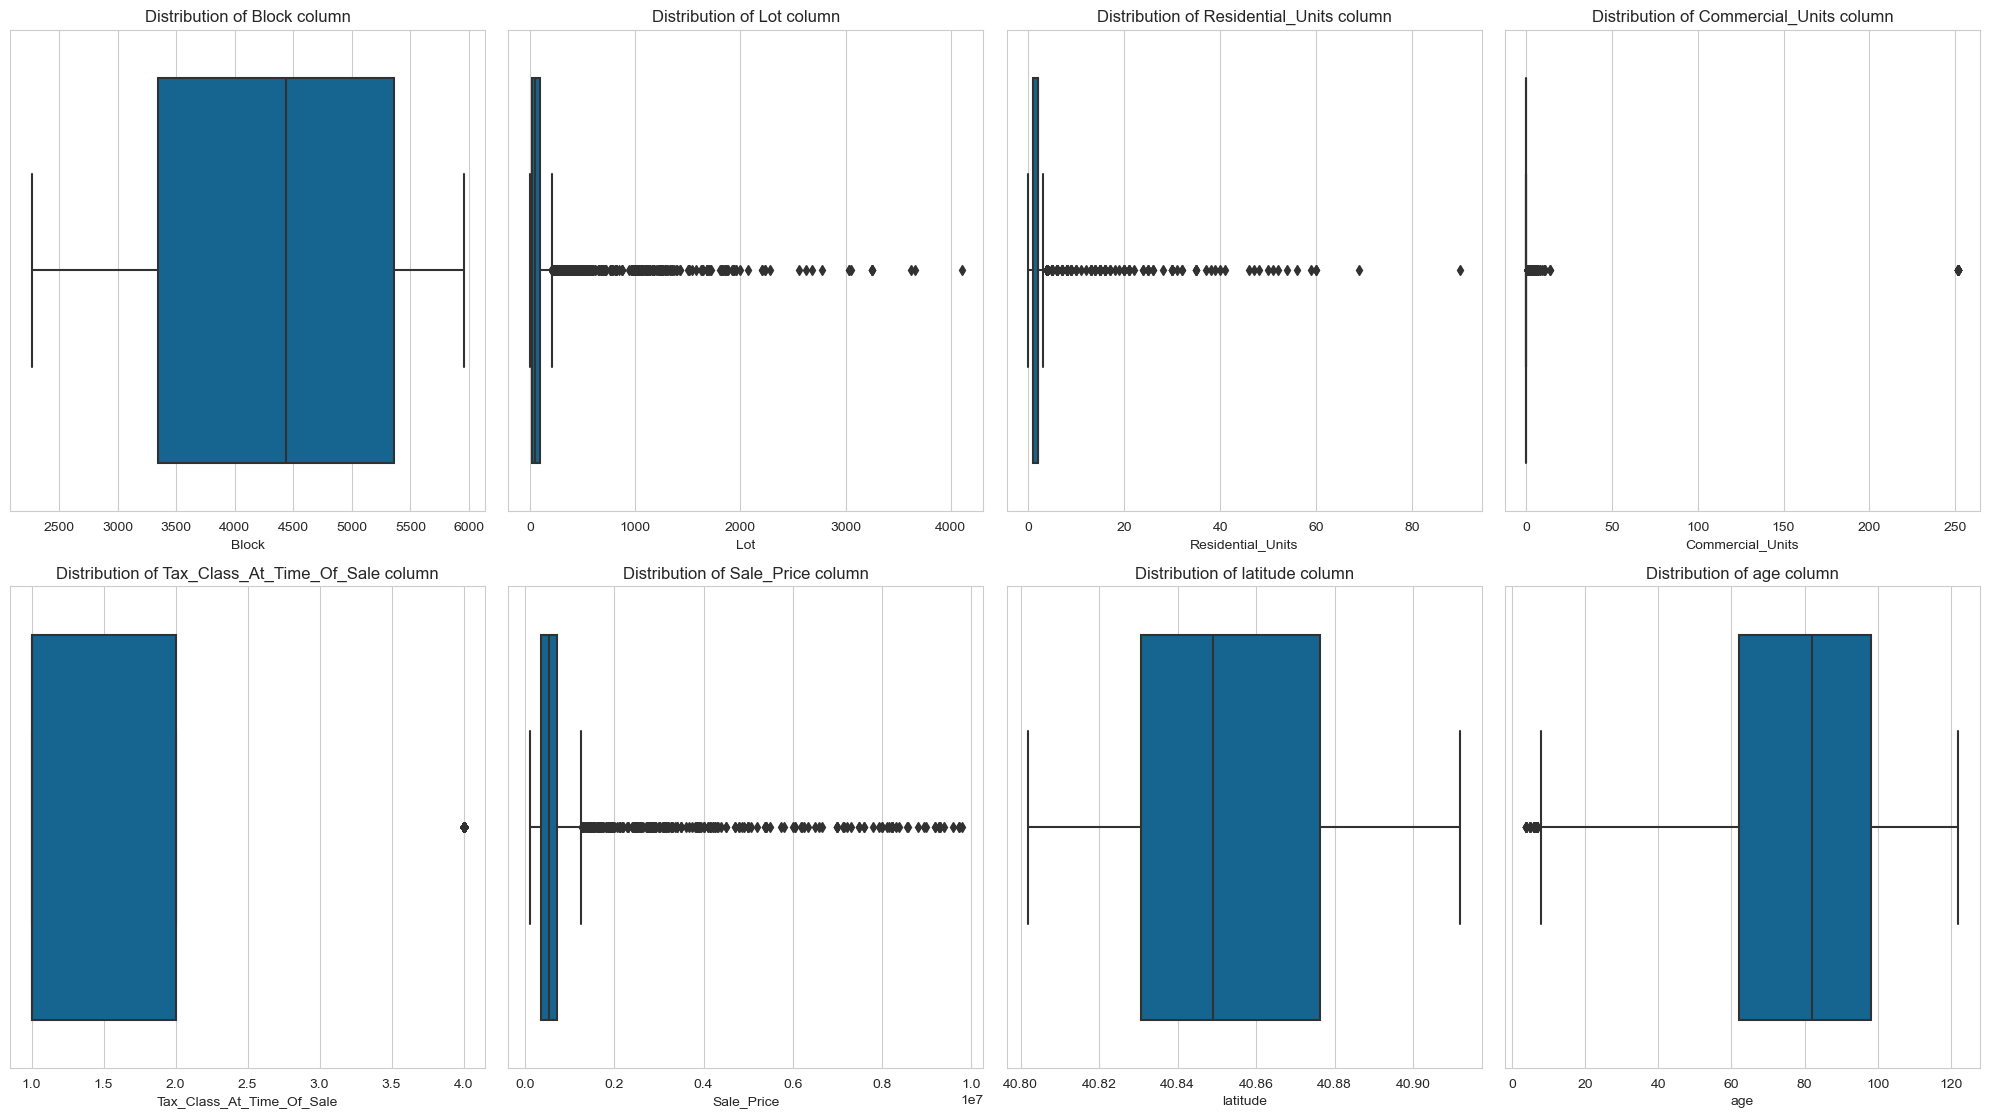

In [250]:
num_cols = df.select_dtypes('number').columns
k = 0
plt.figure(figsize=(20, 100))
for col in num_cols:
    plt.subplot(18, 4, k + 1)
    sns.boxplot(data=df, x=col)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} column")
    k += 1
plt.tight_layout()

/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_2625/2187452470.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop('Sale_Price', axis=1).corr()


<Axes: >

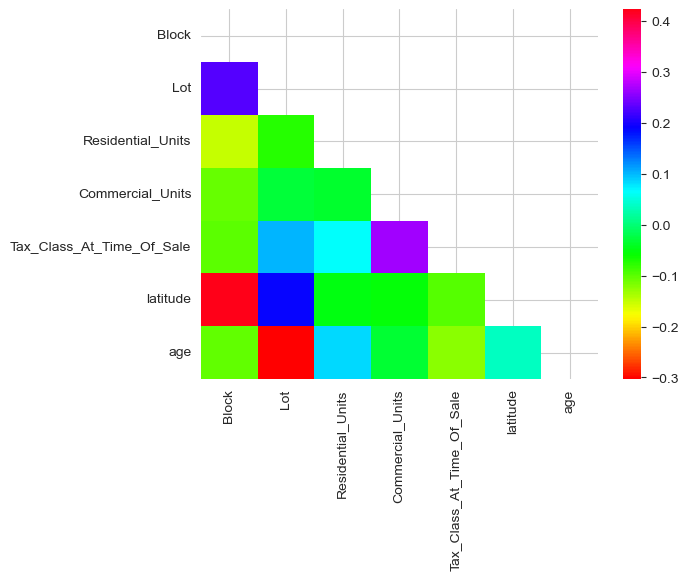

In [252]:
corr = df.drop('Sale_Price', axis=1).corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='hsv')

In [253]:
df.shape


(4396, 10)

In [254]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 1 to 8283
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    4396 non-null   object 
 1   Block                           4396 non-null   int64  
 2   Lot                             4396 non-null   int64  
 3   Residential_Units               3433 non-null   float64
 4   Commercial_Units                3433 non-null   float64
 5   Tax_Class_At_Time_Of_Sale       4396 non-null   int64  
 6   Building_Class_At_Time_Of_Sale  4396 non-null   object 
 7   Sale_Price                      4396 non-null   int64  
 8   latitude                        2636 non-null   float64
 9   age                             4396 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 377.8+ KB


In [255]:
drop_cols = ['Block', 'Lot']
df.drop(columns=drop_cols, axis=1, inplace=True)

In [256]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 1 to 8283
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    4396 non-null   object 
 1   Residential_Units               3433 non-null   float64
 2   Commercial_Units                3433 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       4396 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  4396 non-null   object 
 5   Sale_Price                      4396 non-null   int64  
 6   latitude                        2636 non-null   float64
 7   age                             4396 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 309.1+ KB


In [257]:
df.dropna().info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2636 entries, 1 to 8283
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    2636 non-null   object 
 1   Residential_Units               2636 non-null   float64
 2   Commercial_Units                2636 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       2636 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  2636 non-null   object 
 5   Sale_Price                      2636 non-null   int64  
 6   latitude                        2636 non-null   float64
 7   age                             2636 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 185.3+ KB


In [258]:
df.dropna(inplace=True)


In [259]:
df.shape


(2636, 8)

In [264]:
def treat_categorical(df):
    cat_cols = df.select_dtypes('object').columns
    k = 0
    cardinality_cols = []
    for col in cat_cols:
        value_counts = df[col].value_counts(normalize=True).round(2)
        if len(value_counts) > 5 or len(value_counts) < 2:
            cardinality_cols.append(col)
    return cardinality_cols

def get_low_variance_cols(df):
    num_cols = df.drop('Sale_Price', axis=1).select_dtypes('number').columns
    low_var_cols = []
    for col in num_cols:
        scaled = (df[col] - df[col].mean()) / df[col].std()
        variance = scaled.var().round(2)
        if variance == 0 or df[col].std() == 0:
            low_var_cols.append(col)
    return low_var_cols

def treat_na(df):
    req_cols = []
    for col in df.columns:
        is_na = round(df[col].isna().sum() / len(df) * 100, 2)
        if is_na < 50:
            req_cols.append(col)
    return req_cols
def wrangle(filepath):
    # Import data
    df = pd.read_csv(filepath, index_col=[0])
    print(f"Imported Data, Shape: {df.shape}")
    
    # Filter out the relevant data by sale_price and year_built
    mask = (df['Year Built'] > 1900) & (df['Sale_Price'] > 100000) & (df['Sale_Price'] < 1e7)
    df = df[mask]
    print(f"Created mask, Shape: {df.shape}")
    
    # Remove features which have majority missing values
    req_cols = treat_na(df)
    df = df[req_cols]
    print(f"Filtered Columns by NaN, Shape: {df.shape}")
    
    # Remove high and low cardinality categorical columns
    drop_cols = treat_categorical(df)
    if 'Neighborhood' in drop_cols:
        drop_cols.remove('Neighborhood')
    if 'Building_Class_At_Time_Of_Sale' in drop_cols:
        drop_cols.remove('Building_Class_At_Time_Of_Sale')
    df.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns by Cardinality, Shape: {df.shape}")
    
    # Reduce the cardinality of neighborhood column
    neighborhood = df['Neighborhood'].value_counts(normalize=True).round(2)
    idx = np.where(neighborhood > 0.01)[0].max()
    places = neighborhood.index[:idx]
    df['Neighborhood'] =df['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
    
    # Reduce the cardinality of building_class_at_sale column
    building_class = df['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
    idx = np.where(building_class > 0.01)[0].max()
    places = building_class.index[:idx]
    df['Building_Class_At_Time_Of_Sale'] =df['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
    
    
    # Calculate age of the house
    df['age'] = 2023 - (df['Year Built'] + df['Year Built']) // 2
    
    # Drop unwanted columns
    drop = ['Zip Code', 'Year Built']
    df.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by redundancy, Shape: {df.shape}")
    
    # Drop columns with multicollinearity
    corr = df.drop('Sale_Price', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
    df.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by collinearity, Shape: {df.shape}")
    
    # Drop unwanted columns
    drop_cols = ['Block', 'Lot']
    df.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns manually, Shape: {df.shape}")
    
    # Drop missing values
    df.dropna(inplace=True)
    print(f"Dropped NaN values, Shape: {df.shape}")
    
    return df

In [265]:
bronx = wrangle('Bronx_data.csv')
print(bronx.shape)
bronx.head()

Imported Data, Shape: (8284, 23)
Created mask, Shape: (4396, 23)
Filtered Columns by NaN, Shape: (4396, 21)
Dropped Columns by Cardinality, Shape: (4396, 16)
Dropped Columns by redundancy, Shape: (4396, 15)
Dropped Columns by collinearity, Shape: (4396, 11)
Dropped Columns manually, Shape: (4396, 9)
Dropped NaN values, Shape: (2636, 9)
(2636, 9)


/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_2625/2847416709.py:74: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop('Sale_Price', axis=1).corr()
/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_2625/2847416709.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


,Borough,Neighborhood,Residential_Units,Commercial_Units,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,latitude,age
1,2,OTHER,1.0,0.0,1,OTHER,110000,40.856048,113.0
2,2,OTHER,1.0,0.0,1,A1,470000,40.847655,122.0
5,2,OTHER,2.0,0.0,1,B1,505000,40.837378,30.0
6,2,OTHER,2.0,0.0,1,B1,630000,40.837455,30.0
7,2,OTHER,2.0,0.0,1,B1,535000,40.836752,29.0


In [266]:
bronx.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2636 entries, 1 to 8283
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         2636 non-null   int64  
 1   Neighborhood                    2636 non-null   object 
 2   Residential_Units               2636 non-null   float64
 3   Commercial_Units                2636 non-null   float64
 4   Tax_Class_At_Time_Of_Sale       2636 non-null   int64  
 5   Building_Class_At_Time_Of_Sale  2636 non-null   object 
 6   Sale_Price                      2636 non-null   int64  
 7   latitude                        2636 non-null   float64
 8   age                             2636 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 205.9+ KB


In [267]:
viz_df = bronx.copy()


In [269]:
df['Sale_Price'] = df['Sale_Price'].astype(np.float64)
print(df.dtypes)

Neighborhood                       object
Residential_Units                 float64
Commercial_Units                  float64
Tax_Class_At_Time_Of_Sale           int64
Building_Class_At_Time_Of_Sale     object
Sale_Price                        float64
latitude                          float64
age                               float64
dtype: object


In [271]:
median_home_price = viz_df['Sale_Price'].median()
median_home_price

586000.0

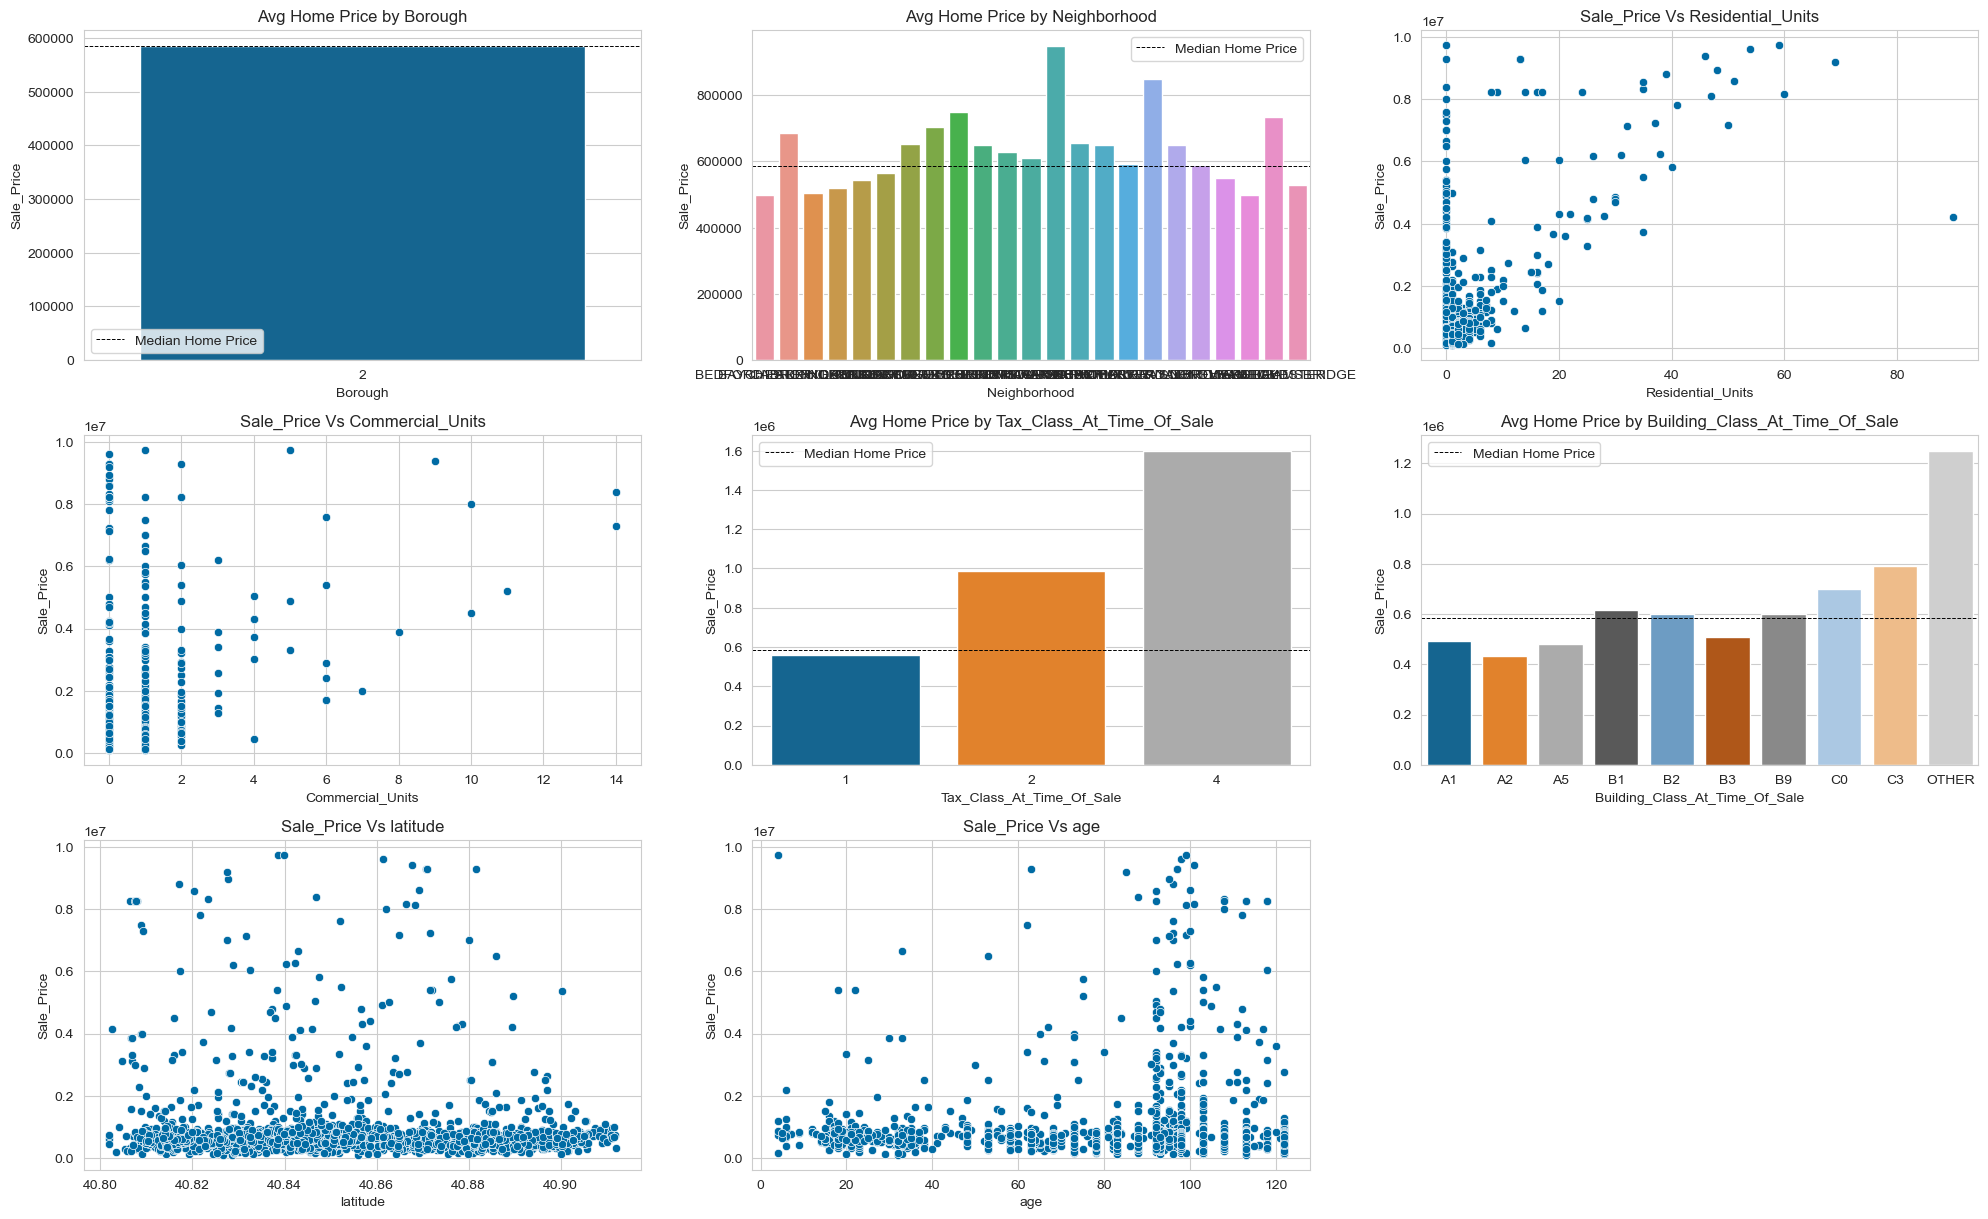

In [274]:
k = 0
plt.figure(figsize=(20, 20))
for col in viz_df.drop('Sale_Price', axis=1).columns:
    plt.subplot(5, 3, k + 1)
    if viz_df[col].dtype == 'float64':
        sns.scatterplot(data=viz_df, x=col, y='Sale_Price')
        plt.title(f"Sale_Price Vs {col}")
    else:
        group = viz_df[[col, 'Sale_Price']].groupby(by=col).median()
        sns.barplot(data=group, x=group.index, y='Sale_Price')
        plt.axhline(y=median_home_price, label='Median Home Price', color='black', linestyle='--', linewidth=0.7)
        plt.title(f"Avg Home Price by {col}")
        plt.legend()
    k += 1
plt.tight_layout()


<Axes: xlabel='Sale_Price', ylabel='Count'>

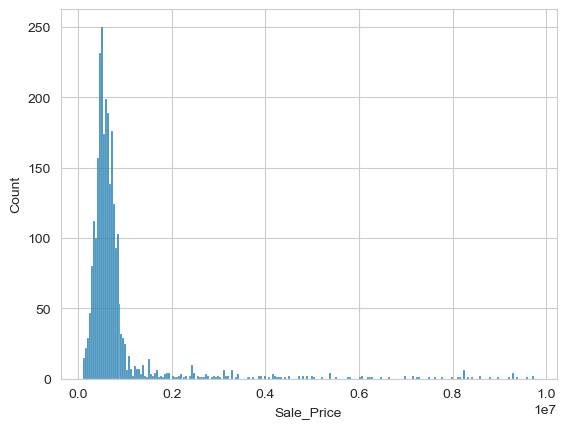

In [275]:
sns.histplot(viz_df['Sale_Price'])


<Axes: xlabel='Sale_Price', ylabel='Count'>

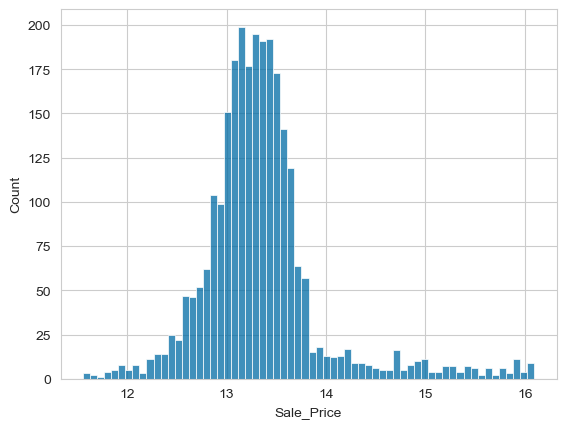

In [277]:
sns.histplot(np.log(viz_df['Sale_Price']))


In [280]:
X_train, X_test, y_train, y_test = train_test_split(bronx.drop('Sale_Price', axis=1), bronx['Sale_Price'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2108, 8), (528, 8), (2108,), (528,))

In [281]:
y_mean = bronx['Sale_Price'].mean().round(2)
print("Baseline R2 Score:", r2_score(y_test, [y_mean] * len(y_test)).round(2))
print("Baseline Root Mean Squared Error:", mean_squared_error(y_test, [y_mean] * len(y_test), squared=False).round(2))

Baseline R2 Score: -0.0
Baseline Root Mean Squared Error: 1049738.1


In [282]:
def train_model(model):
    model.fit(X_train, np.log(y_train))
    print(f"Train R-Squared: {r2_score(y_train, np.exp(model.predict(X_train))).round(2)}")
    print(f"Test R-Squared: {r2_score(y_test, np.exp(model.predict(X_test))).round(2)}")
    print(f"Train Root Mean Squared Error: {mean_squared_error(y_train, np.exp(model.predict(X_train)), squared=False).round(2)}")
    print(f"Test Root Mean Squared Error: {mean_squared_error(y_test, np.exp(model.predict(X_test)), squared=False).round(2)}")
    return model

In [316]:
X_train.columns

Index(['Borough', 'Neighborhood', 'Residential_Units', 'Commercial_Units',
       'Tax_Class_At_Time_Of_Sale', 'Building_Class_At_Time_Of_Sale',
       'latitude', 'age'],
      dtype='object')

In [283]:
rf = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)
rf = train_model(rf)

Train R-Squared: 0.92
Test R-Squared: 0.58
Train Root Mean Squared Error: 320542.47
Test Root Mean Squared Error: 682070.93


In [284]:
params = {
    'randomforestregressor__n_estimators': np.arange(25, 126, 25),
    'randomforestregressor__min_samples_split': np.arange(2, 26, 5)
}
rf_grid = RandomizedSearchCV(
    estimator = rf,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_grid = train_model(rf_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train R-Squared: 0.7
Test R-Squared: 0.59
Train Root Mean Squared Error: 612200.48
Test Root Mean Squared Error: 673347.13


In [285]:
rf_grid.best_estimator_


Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Neighborhood',
                                     'Building_Class_At_Time_Of_Sale'])),
                ('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=22, n_jobs=-1,
                                       random_state=42))])

In [323]:
xgb = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    XGBRegressor(random_state=42, n_jobs=-1),
)
xgb = train_model(xgb)

Train R-Squared: 0.97
Test R-Squared: 0.67
Train Root Mean Squared Error: 185141.76
Test Root Mean Squared Error: 603745.11


In [322]:
cat = CatBoostRegressor(
    cat_features=list(X_train.select_dtypes('object').columns),
    verbose=0
)
cat = train_model(cat)

/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Train R-Squared: 0.84
Test R-Squared: 0.62
Train Root Mean Squared Error: 447611.01
Test Root Mean Squared Error: 648059.34


/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


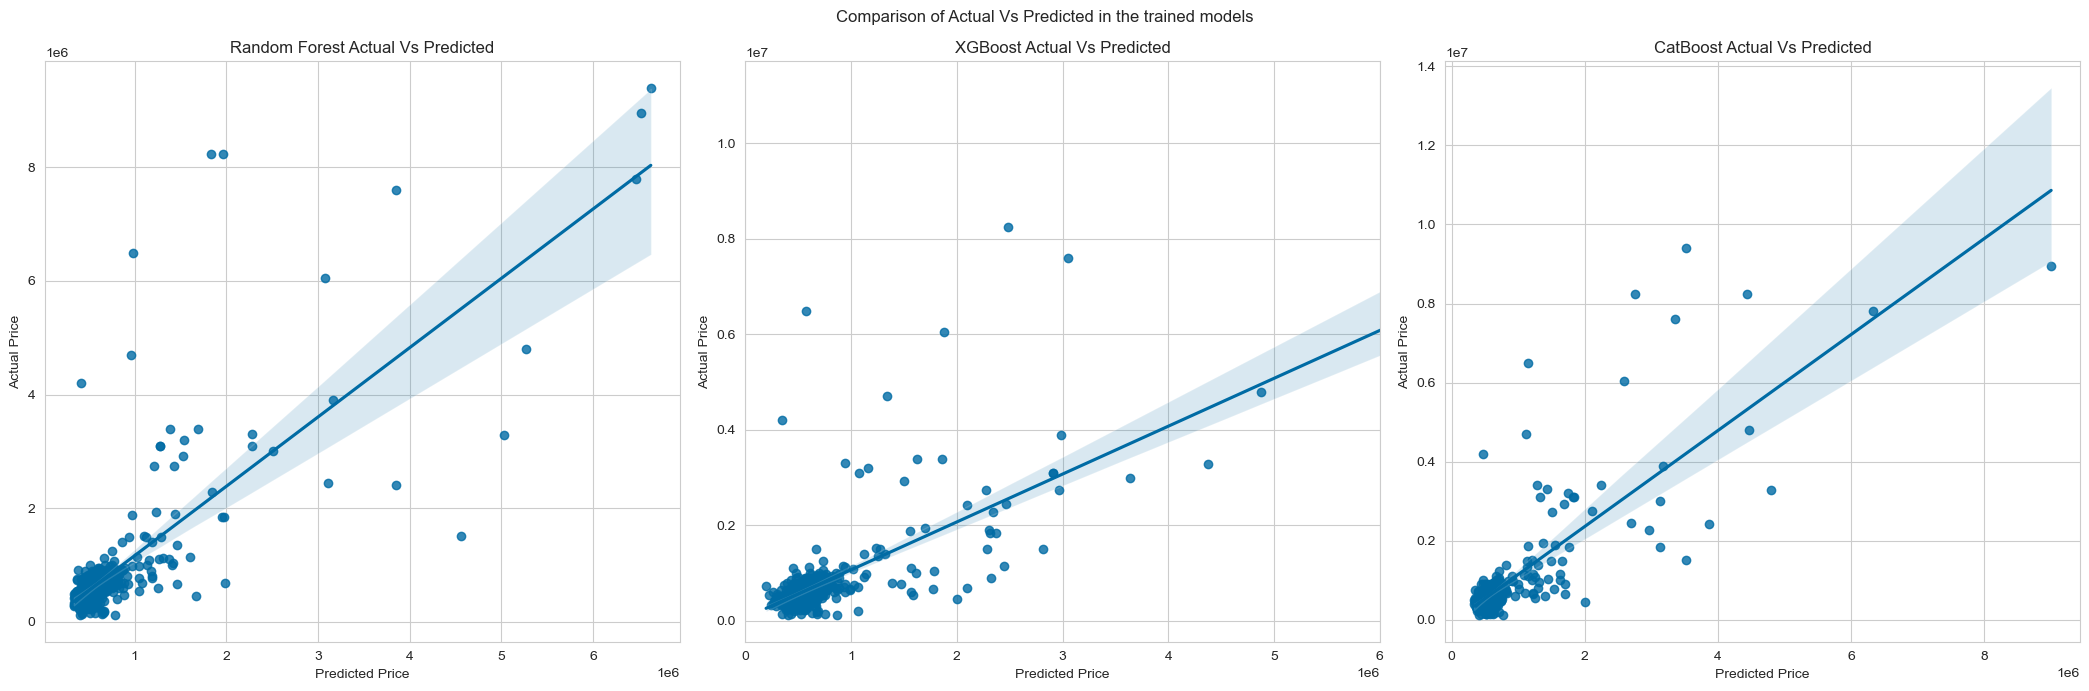

In [289]:
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
preds = np.exp(rf_grid.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Actual Vs Predicted');

plt.subplot(1, 3, 2)
preds = np.exp(xgb.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlim(0, 6e6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Actual Vs Predicted');

plt.subplot(1, 3, 3)
preds = np.exp(cat.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('CatBoost Actual Vs Predicted');

plt.suptitle('Comparison of Actual Vs Predicted in the trained models')
plt.tight_layout()


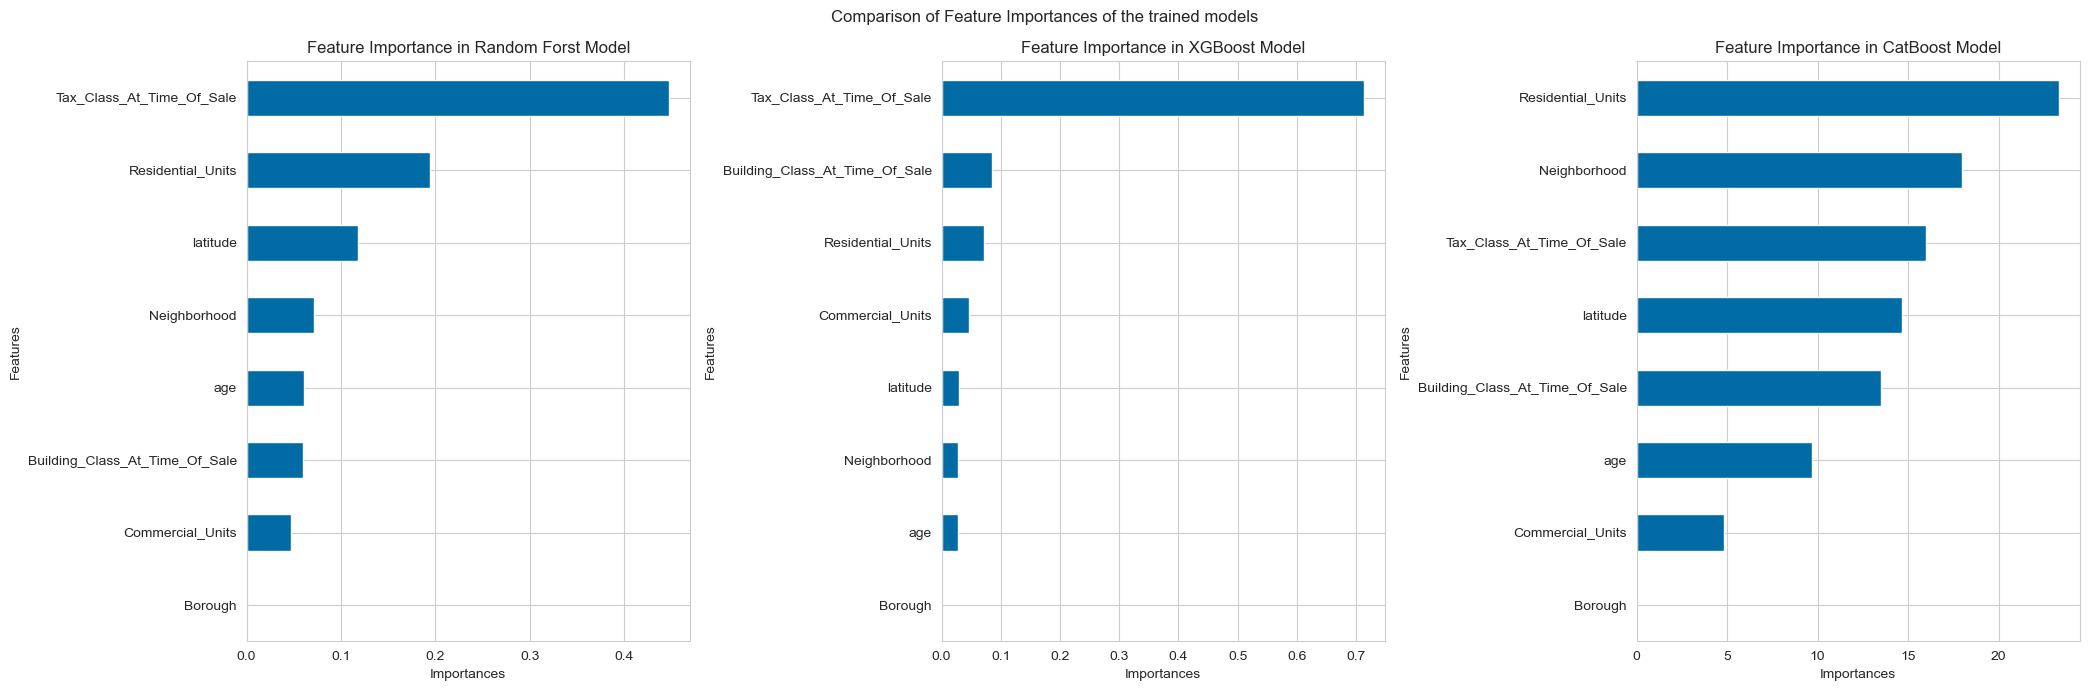

In [290]:
plt.figure(figsize=(21, 7))
feat_imp = rf_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_
rf_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 1)
rf_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forst Model');

feat_imp = xgb.named_steps['xgbregressor'].feature_importances_
xgb_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 2)
xgb_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model');

feat_imp = cat.get_feature_importance()
cat_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 3)
cat_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost Model')

plt.suptitle('Comparison of Feature Importances of the trained models')
plt.tight_layout();

In [291]:
joblib.dump(rf_grid, 'randomforest.pkl', compress=9)
joblib.dump(xgb, 'xgboost.pkl', compress=9)
joblib.dump(cat, 'catboost.pkl', compress=9)

['catboost.pkl']

In [318]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Commercial_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       latitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Commercial_Units': Commercial_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'latitude': latitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('xgboost.pkl', 'rb') as f:
        xgb = joblib.load(f)
        
    xgb_pred = xgb.predict(df)
    
    avg = (np.exp(xgb_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [321]:
predict_house_price(
    Borough = 2,
    Neighborhood = "BATHGATE",
    Residential_Units = 1, 
    Commercial_Units = 0,
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'A1',
    latitude = 40.8476551,
    age = 112
)

'The Predicted House Price is $498373.625'

In [324]:
predict_house_price(
    Borough = 2,
    Neighborhood = "BEDFORD PARK/NORWOOD",
    Residential_Units = 65, 
    Commercial_Units = 0,
    Tax_Class_At_Time_Of_Sale = 2,
    Building_Class_At_Time_Of_Sale = 'C1',
    latitude = 40.8689629,
    age = 112
)

'The Predicted House Price is $5184819.0'

In [325]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Commercial_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       latitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Commercial_Units': Commercial_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'latitude': latitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('randomforest.pkl', 'rb') as f:
        rf_grid = joblib.load(f)
        
    rf_grid_pred = rf_grid.predict(df)
    
    avg = (np.exp(rf_grid_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [326]:
predict_house_price(
    Borough = 2,
    Neighborhood = "BEDFORD PARK/NORWOOD",
    Residential_Units = 65, 
    Commercial_Units = 0,
    Tax_Class_At_Time_Of_Sale = 2,
    Building_Class_At_Time_Of_Sale = 'C1',
    latitude = 40.8689629,
    age = 112
)

'The Predicted House Price is $6514605.46'

In [327]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Commercial_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       latitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Commercial_Units': Commercial_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'latitude': latitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('catboost.pkl', 'rb') as f:
        cat = joblib.load(f)
        
    cat_pred = cat.predict(df)
    
    avg = (np.exp(cat_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [328]:
predict_house_price(
    Borough = 2,
    Neighborhood = "BEDFORD PARK/NORWOOD",
    Residential_Units = 65, 
    Commercial_Units = 0,
    Tax_Class_At_Time_Of_Sale = 2,
    Building_Class_At_Time_Of_Sale = 'C1',
    latitude = 40.8689629,
    age = 112
)

/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


'The Predicted House Price is $2876041.35'